In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
# Setup 

from Helpers import *
from DataCollection import *
import pandas as pd
from ModelBuilding import *
from tensorflow import feature_column
import tensorflow_decision_forests as tfdf
import tensorflow as tf



# If you need to run this yourself, set the environment variable or manually set your key for MLHub here
os.environ['MLHUB_API_KEY'] = os.environ['RADIANT_API_KEY']
NUM_TEST_TILES = 5

In [3]:
collection_id = 'ref_landcovernet_v1_labels'

collection = client.get_collection(collection_id)
print(f'Description: {collection["description"]}')
print(f'License: {collection["license"]}')
print(f'DOI: {collection["sci:doi"]}')
print(f'Citation: {collection["sci:citation"]}')

Description: LandCoverNet Labels
License: CC-BY-4.0
DOI: 10.34911/rdnt.d2ce8i
Citation: Alemohammad S.H., Ballantyne A., Bromberg Gaber Y., Booth K., Nakanuku-Diggs L., & Miglarese A.H. (2020) "LandCoverNet: A Global Land Cover Classification Training Dataset", Version 1.0, Radiant MLHub. [Date Accessed] https://doi.org/10.34911/rdnt.d2ce8i


In [4]:
items = client.list_collection_items(collection_id, limit=1)

first_item = next(items)
all_classes = []

label_classes = first_item['properties']['label:classes']
for label_class in label_classes:
    print("Classes for {}".format(label_class["name"]))
    for c in sorted(label_class['classes']):
        print("f - {}".format(c))
        all_classes.append(c)

Classes for labels
f - (Semi) Natural Vegetation
f - Artificial Bareground
f - Cultivated Vegetation
f - Natural Bareground
f - No Data
f - Permanent Snow/Ice
f - Water
f - Woody Vegetation


In [5]:
# Collect training data
MAX_ITEMS = 1
trainItems = []
bad_ids = ['ref_landcovernet_v1_labels_34MBD_00']
items = get_items(
    collection_id,
    classes=None,
    max_items=50
)
for c in all_classes:
    for item in items:
        if item in trainItems: continue
        # print(item['properties']['label:classes'][0]['classes'])
        # print(item['properties'].keys())
        if c in item['properties']['label:classes'][0]['classes'] and not item['id'] in bad_ids:
            trainItems.append(item)

        if len(trainItems) >= MAX_ITEMS: break

trainIds = []
for i in trainItems:
    if i['id'] not in trainIds:
        if not AlreadyHaveData(i['id'], 'data/train'):
            download_labels_and_source(i, assets=['labels','B02','B03','B04','B08','source_dates','CLD','SCL'], output_dir='./data/train')
            pass
        else:
            print(f'Detected {i["id"]} already - NOT downloading')
        trainIds.append(i['id'])
print("Downloaded/Kept {} training items".format(len(trainIds)))

Detected ref_landcovernet_v1_labels_36MWU_20 already - NOT downloading
Detected ref_landcovernet_v1_labels_35PNR_29 already - NOT downloading
Detected ref_landcovernet_v1_labels_38KMA_26 already - NOT downloading
Detected ref_landcovernet_v1_labels_35PNR_24 already - NOT downloading
Detected ref_landcovernet_v1_labels_38KMA_22 already - NOT downloading
Detected ref_landcovernet_v1_labels_38PKT_07 already - NOT downloading
Detected ref_landcovernet_v1_labels_37PCM_25 already - NOT downloading
Downloaded/Kept 7 training items


In [6]:
# Retrieve test items. Limit these to things NOT in the training set
items = get_items(
    collection_id,
    classes=None,
    max_items=100
)
testIds = []

testItems = []
items = get_items(
    collection_id,
    classes=None,
    max_items=100
)
for c in all_classes:
    for item in items:
        if item in trainItems or item in testItems: continue
        # print(item['properties']['label:classes'][0]['classes'])
        # print(item['properties'].keys())
        if c in item['properties']['label:classes'][0]['classes'] and item['id'] not in bad_ids:
            testItems.append(item)
            break

        if len(testItems) >= 10: break

for i in testItems:
    if not AlreadyHaveData(i['id'], 'data/test'):
        download_labels_and_source(i, assets=['labels','B02','B03','B04','B08','source_dates','CLD','SCL'], output_dir='./data/test')
        pass
    else:
        print(f'Detected {i["id"]} already - NOT downloading')
    testIds.append(i['id'])

print("Downloaded/Kept {} test items".format(len(testIds)))
print(testIds)
print(len(testItems))


Detected ref_landcovernet_v1_labels_36MWU_20 already - NOT downloading
Detected ref_landcovernet_v1_labels_35PNR_29 already - NOT downloading
Detected ref_landcovernet_v1_labels_38KMA_26 already - NOT downloading
Detected ref_landcovernet_v1_labels_35PNR_24 already - NOT downloading
Detected ref_landcovernet_v1_labels_38KMA_22 already - NOT downloading
Detected ref_landcovernet_v1_labels_38PKT_07 already - NOT downloading
Detected ref_landcovernet_v1_labels_37PCM_25 already - NOT downloading
Detected ref_landcovernet_v1_labels_34MDU_17 already - NOT downloading
Downloaded/Kept 8 test items
['ref_landcovernet_v1_labels_36MWU_20', 'ref_landcovernet_v1_labels_35PNR_29', 'ref_landcovernet_v1_labels_38KMA_26', 'ref_landcovernet_v1_labels_35PNR_24', 'ref_landcovernet_v1_labels_38KMA_22', 'ref_landcovernet_v1_labels_38PKT_07', 'ref_landcovernet_v1_labels_37PCM_25', 'ref_landcovernet_v1_labels_34MDU_17']
8


In [7]:
# Create the datasets for testing and training
train_dfc = DFCreator()
trainTiles = ParseIdsForTilesAndChips(trainIds)
trainFrame = train_dfc.GenDF(trainTiles, prefix='data/train')
print("Training with {} tiles".format(len(train_dfc.selectedData)))

test_dfc = DFCreator()
testTiles = ParseIdsForTilesAndChips(testIds)
testFrame = test_dfc.GenDF(testTiles, 'data/test')
print("Testing with {} tiles".format(len(test_dfc.selectedData)))

# Do some additional preprocessing
for num,name in ClassIntMap.items():
    testFrame['classification'] = testFrame['classification'].replace(to_replace=num, value=name)
    trainFrame['classification'] = trainFrame['classification'].replace(to_replace=num, value=name)

print("Training Dataset has the following Classifications: {}".format(np.unique(trainFrame['classification'])))
print("Testing Dataset has the following Classifications: {}".format(np.unique(testFrame['classification'])))

trainSet = tfdf.keras.pd_dataframe_to_tf_dataset(trainFrame.drop('cloudProb', axis=1), label="classification")

testSet = tfdf.keras.pd_dataframe_to_tf_dataset(testFrame.drop('cloudProb', axis=1), label="classification")

Training with 7 tiles
Testing with 8 tiles
Training Dataset has the following Classifications: ['(Semi) Natural Vegetation' 'Artificial Bareground' 'Natural Bareground'
 'Permanent Snow/Ice' 'Woody Vegetation']
Testing Dataset has the following Classifications: ['(Semi) Natural Vegetation' 'Artificial Bareground' 'Natural Bareground'
 'Permanent Snow/Ice' 'Woody Vegetation']


In [8]:
# create RGB images for the images
imgPaths = ['images/train','images/test']

#remove all existing files in the paths first
for dirPath in imgPaths:
    for f in os.listdir(dirPath):
        os.remove(os.path.sep.join([dirPath,f]))

for tile,chip,date in train_dfc.selectedData:
    im = GetRGB(tile,chip,date,'data/train')
    im.save('images/train/{}_{}_{}.jpg'.format(tile,chip,date))
for tile,chip,date in test_dfc.selectedData:
    im = GetRGB(tile,chip,date,'data/test')
    im.save('images/test/{}_{}_{}.jpg'.format(tile,chip,date))

In [9]:
# Create the model and fit to training set
model = tfdf.keras.RandomForestModel()
model.fit(x=trainSet)
model.compile(metrics=['accuracy'])

7168/7168 [==============================] - 8s 775us/step


In [10]:
# Evaluate the model
evaluation = model.evaluate(testSet, return_dict=True)

for name, val in evaluation.items():
    print("{}: {}".format(name,val))

8192/8192 [==============================] - 36s 4ms/step - loss: 0.0000e+00 - accuracy: 0.9839
loss: 0.0
accuracy: 0.9838733673095703


In [11]:
model.save('Model', save_format='tf')
# tf.keras.models.save_model(model, 'Model')

INFO:tensorflow:Assets written to: Model/assets
INFO:tensorflow:Assets written to: Model/assets


In [12]:
model.summary()

Model: "random_forest_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Total params: 1
Trainable params: 0
Non-trainable params: 1
_________________________________________________________________
Type: "RANDOM_FOREST"
Task: CLASSIFICATION
Label: "__LABEL"

Input Features (4):
	band2
	band3
	band4
	band8

No weights

Variable Importance: NUM_NODES:
    1. "band8" 201766.000000 ################
    2. "band3" 187090.000000 #####
    3. "band2" 186261.000000 ####
    4. "band4" 179298.000000 

Variable Importance: NUM_AS_ROOT:
    1. "band4" 230.000000 ################
    2. "band3" 70.000000 

Variable Importance: SUM_SCORE:
    1. "band4" 45950129.770799 ################
    2. "band3" 9512508.859863 ##
    3. "band8" 4093644.544395 
    4. "band2" 3709998.682533 

Variable Importance: MEAN_MIN_DEPTH:
    1. "__LABEL" 13.049354 ################
    2.   "band3"  5.439004 ######
    3.   "band2"  

('36MWU', '20', '20180216')


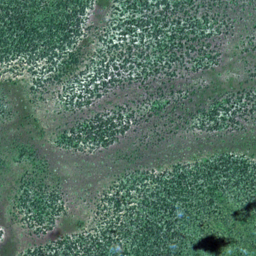

In [13]:
# Show some graphics
from IPython.display import Image as iimage, display
print(train_dfc.selectedData[0])
title,chip,date = train_dfc.selectedData[0]
im = GetRGB(title,chip,date, prefix='data/train')
display(im)